# Movies Experiments on Hypergraph construction

In [2]:
import time
import os
from copy import deepcopy

import json
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


import dhg
from dhg import Graph, Hypergraph
from dhg.data import Cooking200, CocitationCiteseer, HouseCommittees
from dhg.models import GCN, HGNN, HGNNP, UniGCN
from dhg.random import set_seed
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator
from dhg.utils import split_by_ratio

from typing import Optional, Dict, Any, List

import matplotlib.pyplot as plt

from ast import literal_eval
from itertools import combinations

d:\miniconda3\envs\hyper_model\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
set_seed(42)

## EDA

In [ ]:
movie_path = r'.\datasets\movie\movie_dataset.csv'

df = pd.read_csv(movie_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

In [ ]:
dfc = df.copy()
dfc['profitabile'] = dfc['revenue'] - dfc['budget']
dfc['profitabile'] = dfc['profitabile'].apply(lambda x: 1 if x > 0 else 0)

dfc['profitabile'].value_counts()

profitabile
1    2585
0    2218
Name: count, dtype: int64

In [ ]:
dfc.genres.head(5)

0    Action Adventure Fantasy Science Fiction
1                    Adventure Fantasy Action
2                      Action Adventure Crime
3                 Action Crime Drama Thriller
4            Action Adventure Science Fiction
Name: genres, dtype: object

## Experiments

In [ ]:
class HypergraphExperiment:
    def __init__(self, data_path: str):
        self.data_path = data_path
        self.results = []
        self.losses = {}
        
    def run_experiments(self, n_samples=500):
        """Запускает все варианты экспериментов"""
        # 1. Базовый гиперграф (без плотных подграфов)
        print("\n=== Experiment 1: Base Hypergraph ===")
        base_data = MovieHypergraphDataset(
            data_root=self.data_path,
            n_samples=n_samples,
            use_densest_subgraphs=False
        )
        base_results = self._train_and_evaluate(base_data)
        self.results.append(("Base", base_results))
        
        # 2. С топ-k плотными подграфами
        print("\n=== Experiment 2: With Densest Subgraphs ===")
        dense_data = MovieHypergraphDataset(
            data_root=self.data_path,
            n_samples=n_samples,
            use_densest_subgraphs=True,
            k=5
        )
        dense_results = self._train_and_evaluate(dense_data)
        self.results.append(("With Densest Subgraphs", dense_results))
        
        self._visualize_loss()

        # Visualize the results
        self._visualize_results()

    def _train_and_evaluate(self, data) -> Dict[str, float]:
        """Train and evaluate the models on the given dataset."""
        # Get all the data we need
        X = data["features"]
        lbl = data["labels"]
        edge_list = data["edge_list"]
        num_vertices = data["num_vertices"]
        train_mask = data["train_mask"]
        val_mask = data["val_mask"]
        test_mask = data["test_mask"]
        num_classes = data["num_classes"]
        
        # Check if edge_list is empty
        if not edge_list:
            print("Warning: Empty edge list! Creating a fallback edge list based on nearest neighbors.")
            # Create a fallback edge list using k-nearest neighbors
            from sklearn.neighbors import NearestNeighbors
            knn = NearestNeighbors(n_neighbors=5).fit(X.numpy())
            _, indices = knn.kneighbors(X.numpy())
            edge_list = [list(idx) for idx in indices]
        
        # Now use the potentially updated edge_list
        hg = Hypergraph(num_vertices, edge_list)
        masks = {
            "train": train_mask,
            "val": val_mask,
            "test": test_mask
        }
        
        models = {
            "HGNN": HGNN(X.shape[1], 64, num_classes),
            "HGNNP": HGNNP(X.shape[1], 64, num_classes, use_bn=True),
            "UniGCN": UniGCN(X.shape[1], 64, num_classes, use_bn=True),
        }
        
        results = {}
        for name, model in models.items():
            print(f"\nTraining {name}...")
            model = model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            
            best_val_accuracy = 0
            best_val_f1 = 0
            losses = []
            for epoch in range(100):
                loss = train(model, X, hg, lbl, masks["train"], optimizer, epoch)
                losses.append(loss)
                
                if epoch % 5 == 0:
                    val_res = infer(model, X, hg, lbl, masks["val"])
                    # Extract the accuracy value from the dictionary
                    val_accuracy = val_res.get('accuracy', 0)
                    val_f1 = val_res.get('f1_score', 0)
                    if val_accuracy > best_val_accuracy:
                        best_val_accuracy = val_accuracy
                    if val_f1 > best_val_f1:
                        best_val_f1 = val_f1
                        best_state = deepcopy(model.state_dict())
            self.losses[name] = losses
            
            test_res = infer(model, X, hg, lbl, masks["test"], test=True)
            results[name] = {
                "val_accuracy": best_val_accuracy,
                "val_f1": best_val_f1,
                "test_accuracy": test_res.get('accuracy', 0),
                "test_f1": test_res.get('f1_score', 0)
            }
                  
        return results


    def _visualize_loss(self):
        for name, losses in self.losses.items():
            plt.plot(losses, label=name)
        
        plt.title("Losses")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"./images/losses.png")
        plt.show()


    def _visualize_results(self):
        print(self.results)
        """Визуализирует сравнение экспериментов"""
        df_val = pd.DataFrame({
            "Experiment": [exp[0] for exp in self.results],
            "HGNN Val": [exp[1]["HGNN"]["val_accuracy"] for exp in self.results],
            # "HGNN Test": [exp[1]["HGNN"]["test_accuracy"] for exp in self.results],
            "HGNNP Val": [exp[1]["HGNNP"]["val_accuracy"] for exp in self.results],
            # "HGNNP Test": [exp[1]["HGNNP"]["test_accuracy"] for exp in self.results],
            "UniGCN Val": [exp[1]["UniGCN"]["val_accuracy"] for exp in self.results],
            # "UniGCN Test": [exp[1]["UniGCN"]["test_accuracy"] for exp in self.results]
        })
        
        df_test = pd.DataFrame({
            "Experiment": [exp[0] for exp in self.results],
            # "HGNN Val": [exp[1]["HGNN"]["val_accuracy"] for exp in self.results],
            "HGNN Test": [exp[1]["HGNN"]["test_accuracy"] for exp in self.results],
            # "HGNNP Val": [exp[1]["HGNNP"]["val_accuracy"] for exp in self.results],
            "HGNNP Test": [exp[1]["HGNNP"]["test_accuracy"] for exp in self.results],
            # "UniGCN Val": [exp[1]["UniGCN"]["val_accuracy"] for exp in self.results],
            "UniGCN Test": [exp[1]["UniGCN"]["test_accuracy"] for exp in self.results]
        })
        
        plt.figure(figsize=(12, 6))
        ax = df_val.plot(
            x="Experiment",
            # y=["HGNN Val", "HGNN Test", "HGNNP Val", "HGNNP Test", "UniGCN Val", "UniGCN Test"],
            y=["HGNN Val", "HGNNP Val", "UniGCN Val"],
            kind="bar",
            rot=45
        )
        plt.title("Comparison of Hypergraph Construction Methods (Val)")
        plt.ylabel("Accuracy")
        plt.ylim(0, 1)
        plt.legend(loc="lower left")
        plt.tight_layout()
        plt.savefig("./images/hypergraph_comparison_val.png")
        plt.show()
        
        
        plt.figure(figsize=(12, 6))
        ax = df_test.plot(
            x="Experiment",
            y=["HGNN Test", "HGNNP Test", "UniGCN Test"],
            kind="bar",
            rot=45
        )
        plt.title("Comparison of Hypergraph Construction Methods (Test)")
        plt.ylabel("Accuracy")
        plt.ylim(0, 1)
        plt.legend(loc="lower left")
        plt.tight_layout()
        plt.savefig("./images/hypergraph_comparison_test.png")
        plt.show()
        
        print("\n=== Results Summary Val ===")
        print(df_val.to_string(index=False))
        print()
        print("\n=== Results Summary Test ===")
        print(df_test.to_string(index=False))      

In [340]:
class MovieHypergraphDataset:
    def __init__(
        self,
        data_root: str,
        n_samples: Optional[int] = None,
        use_densest_subgraphs: bool = False,
        k: int = 3,
        hyperedge_types: List[str] = ["genre", "director", "numerical"]
    ):
        self.data_root = data_root
        self.n_samples = n_samples
        self.use_densest_subgraphs = use_densest_subgraphs
        self.k = k
        self.hyperedge_types = hyperedge_types
        self._content = self._build_dataset()

    def _build_dataset(self) -> Dict[str, Any]:
        """Build the complete dataset dictionary"""
        # Load and preprocess data
        df = pd.read_csv(self.data_root)
        if self.n_samples:
            df = df.sample(min(self.n_samples, len(df)))

        df = self._preprocess_data(df)
        
        # Create features and labels
        features = self._create_features(df)
        labels = (df['revenue'] > df['budget']).astype(int).values
        
        # Create splits
        train_mask, val_mask, test_mask = self._create_splits(labels)
        
        # Create hyperedges
        edge_list = self._create_hyperedges(df)
        
        # Add densest subgraphs if enabled
        if self.use_densest_subgraphs and len(edge_list) > 0:
            temp_hg = Hypergraph(len(df), edge_list)
            top_k_subgraphs = self._get_top_k_densest_subgraphs(temp_hg, k=self.k)
            edge_list.extend([list(subset) for subset, _ in top_k_subgraphs])
        
        return {
            "num_classes": 2,
            "num_vertices": len(df),
            "num_edges": len(edge_list),
            "features": torch.FloatTensor(features),
            "labels": torch.LongTensor(labels),
            "edge_list": edge_list,
            "train_mask": train_mask,
            "val_mask": val_mask,
            "test_mask": test_mask,
        }

    def _preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Clean and preprocess the raw data"""
        # Convert stringified lists to actual lists
        for col in ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']:
            if col in df.columns:
                df[col] = df[col].apply(
                    lambda x: literal_eval(x) 
                    if pd.notna(x) and isinstance(x, str) and x.startswith('[') 
                    else []
                )
        
        # Handle genres specially if they're space-separated strings
        if 'genres' in df.columns:
            df['genres'] = df['genres'].apply(
                lambda x: [{'name': g.strip()} for g in x.split()] 
                if pd.notna(x) and isinstance(x, str) and not x.startswith('[')
                else x
            )
        
        # Fill missing values
        text_cols = ['overview', 'tagline', 'director']
        for col in text_cols:
            if col in df.columns:
                df[col] = df[col].fillna('')
        
        num_cols = ['runtime', 'budget', 'revenue', 'popularity', 'vote_average', 'vote_count']
        for col in num_cols:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].median())
        
        return df

    def _create_features(self, df: pd.DataFrame) -> np.ndarray:
        """Create feature matrix combining numerical and text features"""
        # Numerical features
        num_features = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
        X_num = StandardScaler().fit_transform(df[num_features].values) if num_features else np.zeros((len(df), 0))
        
        # Text features from overview
        tfidf = TfidfVectorizer(max_features=200, stop_words='english')
        X_text = tfidf.fit_transform(df['overview']).toarray() if 'overview' in df.columns else np.zeros((len(df), 0))
        
        return np.concatenate([X_num, X_text], axis=1)

    def _create_splits(self, labels: np.ndarray) -> tuple:
        """Create train/val/test splits with stratification"""
        indices = np.arange(len(labels))
        train_idx, test_idx = train_test_split(indices, test_size=0.3, stratify=labels)
        val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=labels[test_idx])
        
        train_mask = torch.zeros(len(labels), dtype=torch.bool)
        val_mask = torch.zeros(len(labels), dtype=torch.bool)
        test_mask = torch.zeros(len(labels), dtype=torch.bool)
        
        train_mask[train_idx] = True
        val_mask[val_idx] = True
        test_mask[test_idx] = True
        
        return train_mask, val_mask, test_mask

    def _create_hyperedges(self, df: pd.DataFrame) -> list:
        """Create hyperedges based on specified types"""
        edge_list = []
        
        if "genre" in self.hyperedge_types and 'genres' in df.columns:
            genre_to_movies = {}
            for idx, genres in enumerate(df['genres']):
                if isinstance(genres, list):
                    for genre in genres:
                        name = genre['name'] if isinstance(genre, dict) else genre
                        if name not in genre_to_movies:
                            genre_to_movies[name] = []
                        genre_to_movies[name].append(idx)
            edge_list.extend(list(genre_to_movies.values()))
        
        if "director" in self.hyperedge_types and 'director' in df.columns:
            director_to_movies = {}
            for idx, director in enumerate(df['director']):
                if pd.notna(director):
                    if director not in director_to_movies:
                        director_to_movies[director] = []
                    director_to_movies[director].append(idx)
            edge_list.extend(list(director_to_movies.values()))
        
        if "numerical" in self.hyperedge_types:
            numerical_features = ['budget', 'popularity', 'runtime', 'vote_average']
            X_num = df[numerical_features].values
            knn = NearestNeighbors(n_neighbors=5).fit(X_num)
            _, indices = knn.kneighbors(X_num)
            edge_list.extend([list(idx) for idx in indices])
        
        return edge_list

    def _get_top_k_densest_subgraphs(self, hg: Hypergraph, k: int = 3) -> list:
        """Find top-k densest subgraphs using greedy approximation"""
        nodes = set(range(hg.num_v))
        subgraphs = []
        
        for _ in range(k):
            if len(nodes) < 3:  # min_size
                break
                
            current_nodes = set(nodes)
            best_subset = None
            best_density = -1
            
            while len(current_nodes) >= 3:
                edge_count = sum(1 for e in hg.e[0] if set(e).issubset(current_nodes))
                density = edge_count / len(current_nodes)
                
                if density > best_density:
                    best_density = density
                    best_subset = set(current_nodes)
                
                # Remove node with lowest degree
                degrees = {v: sum(v in e for e in hg.e[0]) for v in current_nodes}
                node_to_remove = min(degrees.items(), key=lambda x: x[1])[0]
                current_nodes.remove(node_to_remove)
            
            if best_subset:
                subgraphs.append((best_subset, best_density))
                nodes -= best_subset
        
        return subgraphs

    def __getitem__(self, key):
        return self._content[key]

In [362]:
def train(net, X, A, lbls, train_idx, optimizer, epoch):
    net.train()
    optimizer.zero_grad()
    outs = net(X, A)
    outs, lbls = outs[train_idx], lbls[train_idx]
    loss = F.cross_entropy(outs, lbls)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Loss: {loss.item():.5f}")
    return loss.item()


@torch.no_grad()
def infer(net, X, A, lbls, idx, test=False):
    net.eval()
    outs = net(X, A)
    outs, lbls = outs[idx], lbls[idx]
    if not test:
        res = evaluator.validate(lbls, outs)
    else:
        res = evaluator.test(lbls, outs)
    
    # Handle both cases: when evaluator returns dict or float
    if isinstance(res, dict):
        return res
    else:
        return {'accuracy': res, 'f1_score': res}  


def evaluate_model(model, hypergraph_type, X, hg, labels, masks):
    results = {}
    for name, mask in masks.items():
        res = infer(model, X, hg, labels, mask, test=(name == "test"))
        results[f"{hypergraph_type}_{name}"] = res
    return results


=== Experiment 1: Base Hypergraph ===


C:\Users\rustem_izmailov\AppData\Local\Temp\ipykernel_1216\2834835554.py:68: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  lambda x: [{'name': g.strip()} for g in x.split()]



Training HGNN...
Epoch: 0, Loss: 0.69275
Epoch: 1, Loss: 0.66751
Epoch: 2, Loss: 0.64399
Epoch: 3, Loss: 0.62005
Epoch: 4, Loss: 0.59748
Epoch: 5, Loss: 0.57722
Epoch: 6, Loss: 0.56126
Epoch: 7, Loss: 0.55088
Epoch: 8, Loss: 0.54155
Epoch: 9, Loss: 0.53810
Epoch: 10, Loss: 0.53098
Epoch: 11, Loss: 0.52912
Epoch: 12, Loss: 0.52214
Epoch: 13, Loss: 0.51526
Epoch: 14, Loss: 0.51033
Epoch: 15, Loss: 0.50401
Epoch: 16, Loss: 0.49680
Epoch: 17, Loss: 0.49455
Epoch: 18, Loss: 0.49382
Epoch: 19, Loss: 0.48841
Epoch: 20, Loss: 0.48594
Epoch: 21, Loss: 0.48648
Epoch: 22, Loss: 0.48898
Epoch: 23, Loss: 0.48500
Epoch: 24, Loss: 0.48525
Epoch: 25, Loss: 0.48145
Epoch: 26, Loss: 0.48317
Epoch: 27, Loss: 0.47578
Epoch: 28, Loss: 0.47731
Epoch: 29, Loss: 0.47532
Epoch: 30, Loss: 0.47534
Epoch: 31, Loss: 0.47260
Epoch: 32, Loss: 0.47090
Epoch: 33, Loss: 0.47327
Epoch: 34, Loss: 0.46989
Epoch: 35, Loss: 0.46892
Epoch: 36, Loss: 0.46661
Epoch: 37, Loss: 0.46509
Epoch: 38, Loss: 0.46514
Epoch: 39, Loss: 

C:\Users\rustem_izmailov\AppData\Local\Temp\ipykernel_1216\2834835554.py:68: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  lambda x: [{'name': g.strip()} for g in x.split()]



Training HGNN...
Epoch: 0, Loss: 0.69168
Epoch: 1, Loss: 0.67197
Epoch: 2, Loss: 0.65242
Epoch: 3, Loss: 0.63067
Epoch: 4, Loss: 0.60857
Epoch: 5, Loss: 0.58721
Epoch: 6, Loss: 0.56868
Epoch: 7, Loss: 0.55719
Epoch: 8, Loss: 0.54810
Epoch: 9, Loss: 0.54321
Epoch: 10, Loss: 0.53915
Epoch: 11, Loss: 0.53586
Epoch: 12, Loss: 0.53405
Epoch: 13, Loss: 0.52944
Epoch: 14, Loss: 0.52470
Epoch: 15, Loss: 0.52325
Epoch: 16, Loss: 0.51746
Epoch: 17, Loss: 0.51156
Epoch: 18, Loss: 0.50772
Epoch: 19, Loss: 0.50256
Epoch: 20, Loss: 0.49888
Epoch: 21, Loss: 0.49936
Epoch: 22, Loss: 0.49864
Epoch: 23, Loss: 0.49495
Epoch: 24, Loss: 0.49521
Epoch: 25, Loss: 0.49526
Epoch: 26, Loss: 0.49436
Epoch: 27, Loss: 0.49310
Epoch: 28, Loss: 0.49370
Epoch: 29, Loss: 0.48978
Epoch: 30, Loss: 0.48882
Epoch: 31, Loss: 0.49005
Epoch: 32, Loss: 0.48666
Epoch: 33, Loss: 0.48927
Epoch: 34, Loss: 0.48835
Epoch: 35, Loss: 0.48466
Epoch: 36, Loss: 0.48386
Epoch: 37, Loss: 0.48472
Epoch: 38, Loss: 0.48246
Epoch: 39, Loss: 

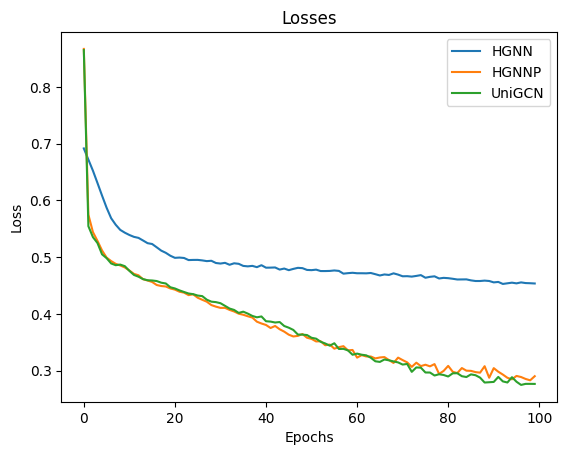

[('Base', {'HGNN': {'val_accuracy': 0.742222249507904, 'val_f1': 0.742222249507904, 'test_accuracy': 0.7333333492279053, 'test_f1': 0.7318022886204705}, 'HGNNP': {'val_accuracy': 0.7400000095367432, 'val_f1': 0.7400000095367432, 'test_accuracy': 0.699999988079071, 'test_f1': 0.6979580472428417}, 'UniGCN': {'val_accuracy': 0.7333333492279053, 'val_f1': 0.7333333492279053, 'test_accuracy': 0.7288888692855835, 'test_f1': 0.7279808149674966}}), ('With Densest Subgraphs', {'HGNN': {'val_accuracy': 0.753333330154419, 'val_f1': 0.753333330154419, 'test_accuracy': 0.7711111307144165, 'test_f1': 0.7671076630874438}, 'HGNNP': {'val_accuracy': 0.7377777695655823, 'val_f1': 0.7377777695655823, 'test_accuracy': 0.7400000095367432, 'test_f1': 0.7373737373737373}, 'UniGCN': {'val_accuracy': 0.742222249507904, 'val_f1': 0.742222249507904, 'test_accuracy': 0.742222249507904, 'test_f1': 0.7354497354497354}})]


<Figure size 1200x600 with 0 Axes>

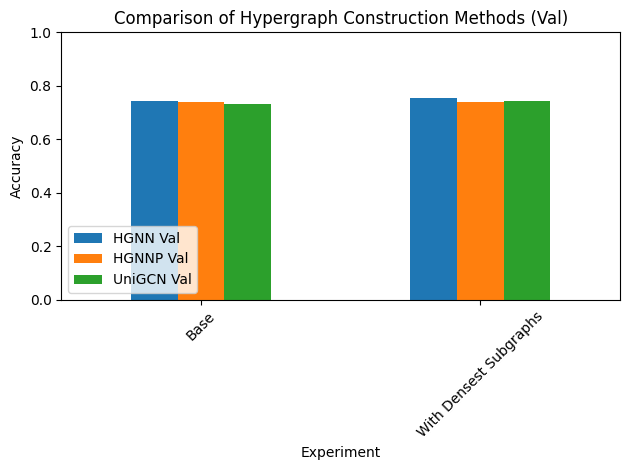

<Figure size 1200x600 with 0 Axes>

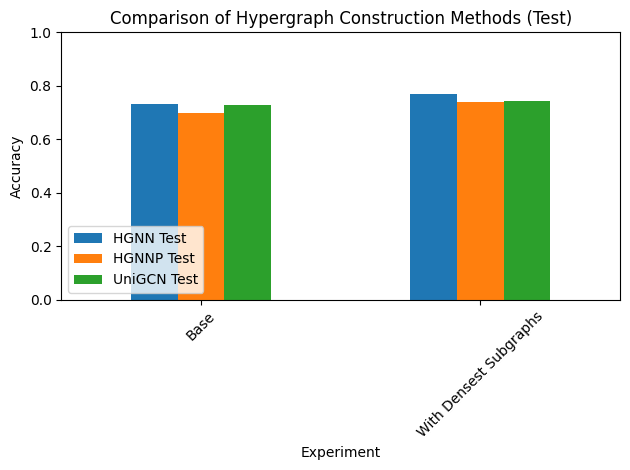


=== Results Summary Val ===
            Experiment  HGNN Val  HGNNP Val  UniGCN Val
                  Base  0.742222   0.740000    0.733333
With Densest Subgraphs  0.753333   0.737778    0.742222


=== Results Summary Test ===
            Experiment  HGNN Test  HGNNP Test  UniGCN Test
                  Base   0.733333        0.70     0.728889
With Densest Subgraphs   0.771111        0.74     0.742222


[('Base',
  {'HGNN': {'val_accuracy': 0.742222249507904,
    'val_f1': 0.742222249507904,
    'test_accuracy': 0.7333333492279053,
    'test_f1': 0.7318022886204705},
   'HGNNP': {'val_accuracy': 0.7400000095367432,
    'val_f1': 0.7400000095367432,
    'test_accuracy': 0.699999988079071,
    'test_f1': 0.6979580472428417},
   'UniGCN': {'val_accuracy': 0.7333333492279053,
    'val_f1': 0.7333333492279053,
    'test_accuracy': 0.7288888692855835,
    'test_f1': 0.7279808149674966}}),
 ('With Densest Subgraphs',
  {'HGNN': {'val_accuracy': 0.753333330154419,
    'val_f1': 0.753333330154419,
    'test_accuracy': 0.7711111307144165,
    'test_f1': 0.7671076630874438},
   'HGNNP': {'val_accuracy': 0.7377777695655823,
    'val_f1': 0.7377777695655823,
    'test_accuracy': 0.7400000095367432,
    'test_f1': 0.7373737373737373},
   'UniGCN': {'val_accuracy': 0.742222249507904,
    'val_f1': 0.742222249507904,
    'test_accuracy': 0.742222249507904,
    'test_f1': 0.7354497354497354}})]

In [ ]:
movie_path = r'.\datasets\movie\movie_dataset.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

experiment = HypergraphExperiment(
    data_path=movie_path
)
experiment.run_experiments(n_samples=3000)

experiment.results

## Results

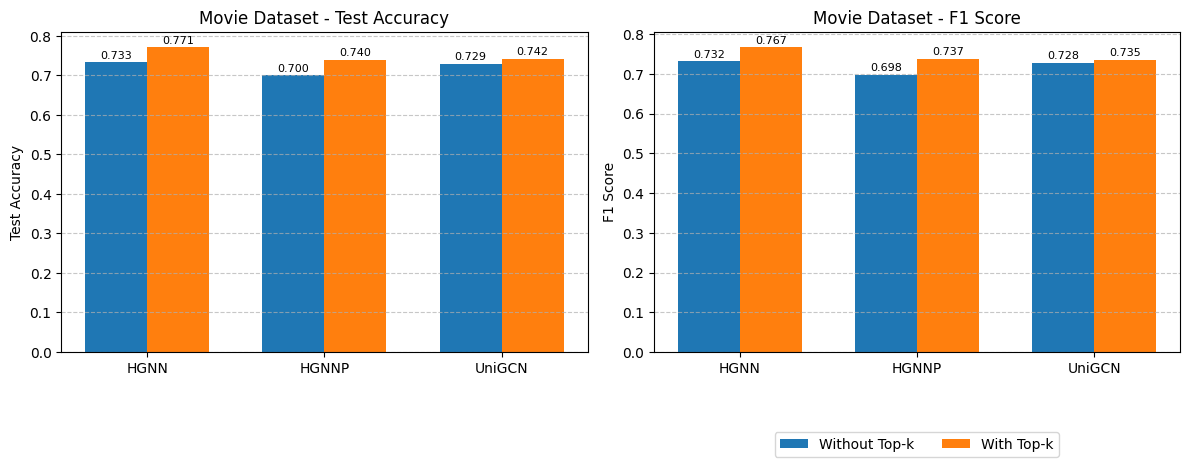

In [416]:
# Grouped bar chart for Movie dataset
def plot_movie_metrics(accuracy_data, f1_data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    metrics = [("Test Accuracy", accuracy_data), ("F1 Score", f1_data)]
    groups = ['HGNN', 'HGNNP', 'UniGCN']
    variations = ['Base', 'With Densest Subgraphs']
    x = np.arange(len(groups))
    width = 0.35

    for ax, (metric_name, metric_data) in zip(axes, metrics):
        bars1 = ax.bar(x - width/2, [metric_data[model][0] for model in groups],
                       width=width, label='Without Top-k')
        bars2 = ax.bar(x + width/2, [metric_data[model][1] for model in groups],
                       width=width, label='With Top-k')

        # Annotate bar values
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=8)

        ax.set_xticks(x)
        ax.set_xticklabels(groups)
        ax.set_ylabel(metric_name)
        ax.set_title(f'Movie Dataset - {metric_name}')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)
    plt.tight_layout()
    plt.show()

plot_movie_metrics(accuracy_data, f1_data)


In [15]:
df = pd.read_csv(r'.\datasets\movie_results.csv')
df

,Model,Base Acc,Top-k Acc,Acc Diff (%),Base F1,Top-k F1,F1 Diff (%)
0,HGNN,0.733333,0.771111,3.78,0.731802,0.767108,3.53
1,HGNNP,0.700000,0.740000,4.00,0.697958,0.737374,3.94
2,UniGCN,0.728889,0.742222,1.33,0.727981,0.735450,0.75
